# Logistic Regression Modeling

In the modeling stage I create machine learning models for predicting fraudulent activity. I will be modeling using the logistic regression and random forest algotrithms. I will first preprocess the data by scaling the "Amount" column. The other columns should already be scaled since they are a product of principal component analysis. Then I will create a baseline model and then I will experiment with feature selection, resampling, PCA, and hyper-parameter tuning. My goal here is a high recall score. The higher the recall score the fewer frauds go undetected. Recall must be balanced with precision, which is equal to the amount of true positives divided by the sum of the amount of true positives and false negatives. essentially the inverse of the rate the model falsely flags normal transactions as fraudulent. My goal is to have recall as high as possible with precision above %20. With the data being only %0.2 frauds, this will mean that I incorrectly flag a transaction as fraud %0.08 of the time. After all the modeling is done, I will take the best classifier and conduct a final evaluation on the testing set to get an idea of how the model will work on unseen data.

In [35]:
# import libaries

# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# plotting trees
from IPython.display import Image
from sklearn.tree import export_graphviz

# ML metrics
from sklearn.metrics import recall_score, precision_score

# feature selection
from sklearn.feature_selection import RFE

# resampling
from imblearn.over_sampling import SMOTE

# PCA
from sklearn.decomposition import PCA

# hyper parameter tuning
from sklearn.model_selection import ParameterGrid


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# load data
train = pd.read_csv("train.csv")

# create validation setdef get_scores(y, yhat):

X, y = train.drop("Class", axis=1), train.Class

sss = StratifiedShuffleSplit(test_size=0.15)

train_index, val_index = next(sss.split(X, y))

val = train.iloc[val_index]
train = train.iloc[train_index]

X_train, y_train = train.drop("Class", axis=1), train.Class
X_val, y_val = val.drop("Class", axis=1), val.Class

# Helper Functions

Here I set aside some helper functions for running predictions and finding the best probability threshold to predict with. Changing the probability threshold allows me to trade precision performance with recall performance. I want the final product to have as much recall capability as possible with atleast %20 precision. So I will set the threshold to return approximately %30 precision on the training set, due to the fact precision is likely to drop when used on new data.

In [5]:
def get_scores(y, yhat):
    """
    Prints out recall and precision scores. Returns an empty string.
    ~
    Parameters:
    y: A 1D array of labels
    yhat: A 1D array of predicted labels
    ~
    Returns:
    None
    """
    print("Recall:   ", round(recall_score(y, yhat), 3))
    print("Precision:", round(precision_score(y, yhat), 3))

    return ""

def apply_threshold(probs, threshold):
    """
    Takes a list of probabilities and a threshold and returns 
    a list of predictions
    ~
    Parameters:
    probs: a 1D array of probability predictions (from an sklearn classifier)
    threshold: a float that represents the probability threshold to create labels with
    ~
    Returns:
    A 1D array of labels
    """
    
    return [1 if p >= threshold else 0 for p in probs]

def find_best_threshold(y, probs, cutoff=0.3):
    """
    Takes in labels, probability predictions, and a cutoff point. Finds the 
    best threshold to label the predictions with a precision score equal to or
    slightly above the cutoff point. This allows for optimal recall scores.
    ~
    Parameters:
    y: A 1D array of labels
    probs: A 1D array of probability predictions (from an sklearn classifier)
    cutoff: A float indicating the minimum amount of precision desired 
    ~
    Returns:
    threshold: the optimal threshold for labeling prediction probabilities
    """
    
    # instantiate a close-to-zero threshold
    threshold = 0.001
    
    # instantiate a precision score of 0
    prec_score = 0
    
    # while the current precision score is below the cutoff
    while (prec_score <= cutoff):
        
        # increase threshold slightly
        threshold = 0.0005 + threshold
        
        # label predictions
        predictions = apply_threshold(probs, threshold)

        # find new precision score and update
        prec_score = precision_score(y, predictions)
        

            
    return threshold

def predict_w_threshold(fit_clf, X, threshold):
    """
    Takes in an already fit classifier, X-values, and a threshold. Makes predictions using 
    a custom threshold.
    ~
    Parameters:
    fit_clf: An sklearn classifier that is already fit on training data
    X: An 2D array of X values
    threshold: A float representing the threshold to label the prediction probabilities with
    ~ 
    Returns:
    A list of labels
    """
    # find probability predictions
    probs = fit_clf.predict_proba(X)[:, 1]
    
    # label using threshold
    return apply_threshold(probs, threshold)
    
    
    

def fit_predict(clf, X_train, y_train, X_val, y_val):
    """
    Takes a classifier with training and validation data. Adjusts the probability
    threshold using the training set. Prints out precision and recall scores for both
    the training and validation sets. Returns None.
    ~
    Parameters:
    clf: An sklearn classifier
    X_train: A 2D array of X values belonging to the training set
    y_train: A 1D array of labels belonging to the training set
    X_val: A 2D array of X values belonging to the validation set
    y_val: A 1D array of labels belonging to the validation set   
    ~
    Returns: None
    """
    
    clf.fit(X_train, y_train)
    
    probs_train = clf.predict_proba(X_train)[:, 1]
    
    threshold = find_best_threshold(y_train, probs_train)
    
    yhat_train = apply_threshold(probs_train, threshold)
    
    
    yhat_val = predict_w_threshold(clf, X_val, threshold)

    print("training")
    print(get_scores(y_train, yhat_train))
    print("validation")
    print(get_scores(y_val, yhat_val))

# Preprocess the Amount Column

In [6]:
# preprocessing
sc = StandardScaler()

X_train.Amount = sc.fit_transform(X_train.Amount.values.reshape(-1, 1))
X_val.Amount = sc.transform(X_val.Amount.values.reshape(-1, 1))

# 1.0 Logistic Regression

## 1.1 Baseline Model

Here I will see how well the model predicts without changing anything other than the probability threshold for predictions. I will use this as a baseline to compare with altered versions of the model and training data. I will also use this model to examine its coefficients, which I can use to get an idea of what features are more important.

In [16]:
# create a logistic regression model
lr = LogisticRegression()

# fit, find threshold, predict, and get scores
fit_predict(lr, X_train, y_train, X_val, y_val)


training
Recall:    0.883
Precision: 0.307




validation

Recall:    0.783
Precision: 0.261



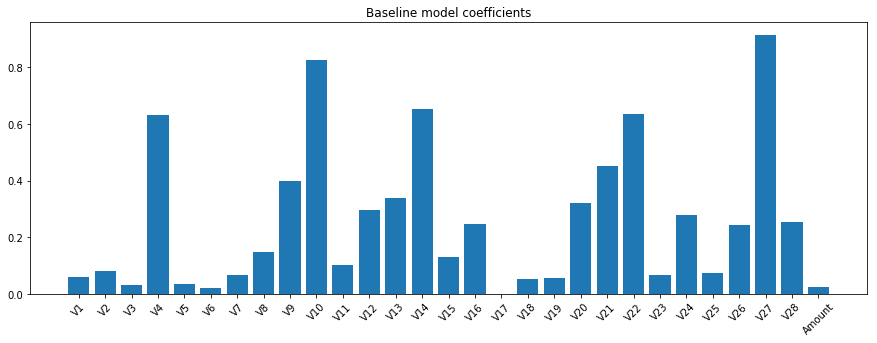

In [108]:
# plot coefficients (absolute values)
plt.figure(figsize=(15, 5))
plt.bar(X_train.columns, abs(lr.coef_[0]))
plt.xticks(rotation=45)
plt.title("Baseline model coefficients")
plt.show()

We can see here that some features hold much less weight than others. 

## 1.2 Feature Selection

Now I will experiment with using less features. I will do this using recursive feature elimination. I will create 27 RFE objects with n_features_to_select 1 through 27 respectively. Then I will compare the recall scores of each RFE object to see which one performs the best. This will allow me to extract the best features.

In [26]:
# create 27 RFEs to find the best features

# create collections to store RFEs and results
rfe_collection = {}
scores_collection = []

for i in range(1, 29):
    
    # create new RFE object
    rfe = RFE(lr, i)
    
    # fit
    rfe.fit(X_train, y_train)
    
    # find the best threshold for ~%30 precision
    probs_train = rfe.predict_proba(X_train)[:, 1]
    threshold = find_best_threshold(y_train, probs_train)
    
    # predict using threshold and save scores
    # for training and validation sets
    yhat_train = predict_w_threshold(rfe, X_train, threshold)
    yhat_val = predict_w_threshold(rfe, X_val, threshold)
    
    # precisions
    pscore_train = precision_score(y_train, yhat_train)
    pscore_val = precision_score(y_val, yhat_val)
    
    # recalls
    rscore_train = recall_score(y_train, yhat_train)
    rscore_val = recall_score(y_val, yhat_val)
    
    # store scores in a collection
    scores_collection.append({
        "n features":i,
        "training recall":rscore_train,
        "training precision":pscore_train,
        "validation recall":rscore_val,
        "validation precision":pscore_val       
    })
    
    
    rfe_collection[i] = rfe
    
    print(f"{i}/28")

1/29
2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29


In [27]:
# display results
pd.DataFrame(scores_collection)

i  training precision  training recall  validation precision  \
0    1            0.305677         0.818713              0.309859   
1    2            0.309168         0.847953              0.316901   
2    3            0.323725         0.853801              0.330882   
3    4            0.312831         0.862573              0.286624   
4    5            0.317647         0.868421              0.294872   
5    6            0.316348         0.871345              0.291139   
6    7            0.316969         0.868421              0.292683   
7    8            0.328918         0.871345              0.296296   
8    9            0.302115         0.877193              0.265193   
9   10            0.303030         0.877193              0.262295   
10  11            0.304569         0.877193              0.256684   
11  12            0.311526         0.877193              0.269663   
12  13            0.306122         0.877193              0.258065   
13  14            0.318519         0.880117              0.277457   
14  15            0.300199         0.883041              0.268156   
15  16            0.322650         0.883041              0.286585   
16  17            0.305978         0.883041              0.290909   
17  18            0.329682         0.880117              0.288344   
18  19            0.346375         0.880117              0.311258   
19  20            0.332965         0.880117              0.281437   
20  21            0.302000         0.883041              0.256684   
21  22            0.305978         0.883041              0.256831   
22  23            0.307536         0.883041              0.265193   
23  24            0.310062         0.883041              0.268156   
24  25            0.306288         0.883041              0.266667   
25  26            0.308793         0.883041              0.263736   
26  27            0.305978         0.883041              0.261111   
27  28            0.306599         0.883041              0.261111   

    validation recall  
0            0.733333  
1            0.750000  
2            0.750000  
3            0.750000  
4            0.766667  
5            0.766667  
6            0.800000  
7            0.800000  
8            0.800000  
9            0.800000  
10           0.800000  
11           0.800000  
12           0.800000  
13           0.800000  
14           0.800000  
15           0.783333  
16           0.800000  
17           0.783333  
18           0.783333  
19           0.783333  
20           0.800000  
21           0.783333  
22           0.800000  
23           0.800000  
24           0.800000  
25           0.800000  
26           0.783333  
27           0.783333

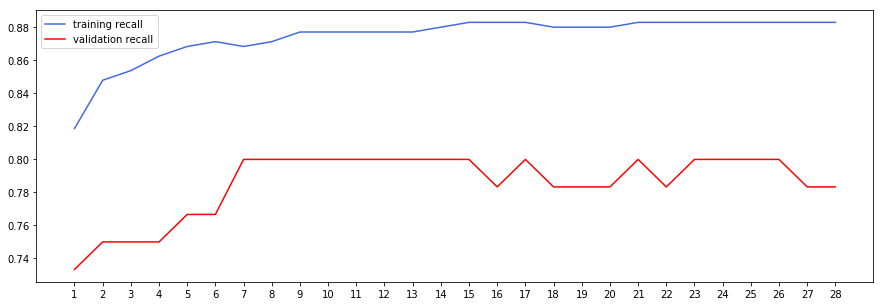

In [32]:
# create an ordered list of recall scores
n_feats = [j["n features"] for j in scores_collection]
train_recall_list = [j["training recall"] for j in scores_collection]
val_recall_list = [j["validation recall"] for j in scores_collection]

# plot
plt.figure(figsize=(15, 5))
plt.plot(n_feats, train_recall_list, label="training recall", color="royalblue")
plt.plot(n_feats, val_recall_list, label="validation recall", color="red")
plt.xticks(range(1, 29))
plt.legend()
plt.title("Recall Scores VS Number of Features")
plt.show()


In [109]:
# get rfe for 7 features
rfe7 = rfe_collection[7]

In [110]:
feats_chosen = zip(train.columns, rfe7.support_)
best_feats = []
for col, is_chosen in feats_chosen:
    if is_chosen:
        best_feats.append(col)
        
best_feats

['V4', 'V10', 'V13', 'V14', 'V21', 'V22', 'V24']

Now I will test out a model using the best features.

In [114]:
# create a new version of X_train and X_val with only the best features
X_train_bf, X_val_bf = X_train[best_feats], X_val[best_feats]

In [113]:
fit_predict(lr, X_train_bf, y_train, X_val_bf, y_val)

training
Recall:    0.868
Precision: 0.334

validation
Recall:    0.783
Precision: 0.29



## 1.3 PCA

Now I will try using principal component analysis to reduce the amount of features and see if that gives better results. I will fit a PCA object to the X_train and examine the explained variance ratio. I will take the minimal amount of components to achieve an explained variance ratio of 0.95. I will plug in that number of components into a new PCA object and I will use that to transform the data. Then I can see if it produces better results.

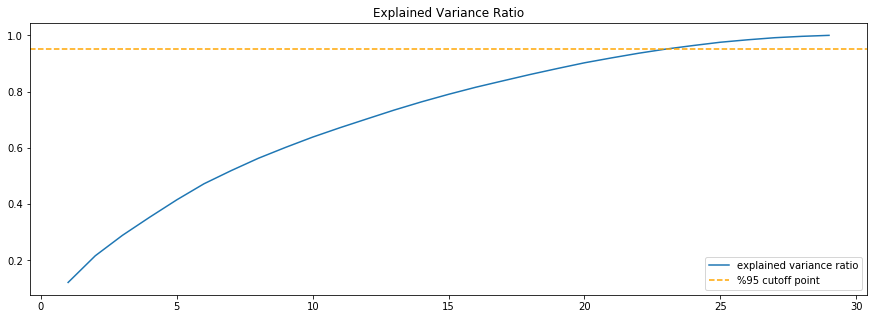

In [117]:
# fit PCA object
pca = PCA(29)
pca.fit(X_train)

# plot explained variance ratio
plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), np.cumsum(pca.explained_variance_ratio_), label="explained variance ratio")
plt.axhline(0.95, color="orange", linestyle="--", label="%95 cutoff point")
plt.title("Explained Variance Ratio")
plt.legend()
plt.show()

In [22]:
# transform data
# the explained variance ratio hit the cutoff point at 24 components
pca = PCA(24)
pca.fit(X_train)
X_train_pca, X_val_pca = pca.transform(X_train), pca.transform(X_val)

In [120]:
# examine results
fit_predict(lr, X_train_pca, y_train, X_val_pca, y_val)

training
Recall:    0.874
Precision: 0.331

validation
Recall:    0.783
Precision: 0.307



## 1.4 Resampling

Now I will see if resampling the data will help. The data is highly imbalanced with a normal to fraud ratio of 500:1. This can introduce bias in the machine learning algorithm. The SMOTE algorithm will create artificial fraud cases in the training data to help balance it. Only the training data should be resampled.

In [25]:
# create SMOTE object
sm = SMOTE()

# upsample data
X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

# examine results
fit_predict(lr, X_train_rs, y_train_rs, X_val, y_val)

The model did well on the training set, but had terrible precision on the validation set. This is a sign of overfitting. This might be helped by hyper-parameter tuning. Let's examine a plot of the precision-recall tradeoff.

In [122]:
# get probability predictions for the training set
probs_train = lr.predict_proba(X_train_rs)[:, 1]

In [29]:
def tradeoff_plot(y, probs):
    
    recalls = []
    precisions = []
    thresholds = np.linspace(0, 1, 50)
    
    for th in thresholds:
        predictions = apply_threshold(probs, th)
        recalls.append(recall_score(y, predictions))
        precisions.append(precision_score(y, predictions))
        
    plt.figure(figsize=(15, 5))
    plt.plot(thresholds, recalls, color="red", label="recall")
    plt.plot(thresholds, precisions, color="royalblue", label="precision")
    plt.title("Precision Recall Tradeoff")
    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.legend()
    plt.show()

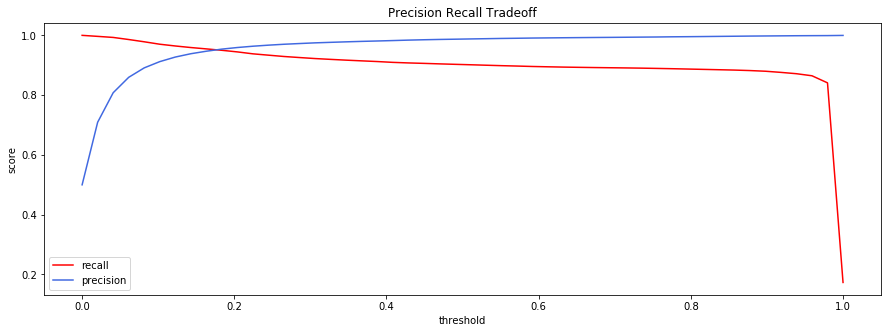

In [129]:
# plot precision recall tradeoff
tradeoff_plot(y_train_rs, probs_train)

The problem here is that the function "fit_predict" I made was searching for a threshold to meet %30. You can see in this graph that the model always had over %30 precision. So I will adjust the threshold to say 0.20.

In [135]:
# predict on validation set using a threshold of 0.10
yhat_val = predict_w_threshold(lr, X_val, 0.20)

# get scores
get_scores(y_val, yhat_val)

Recall:    0.883
Precision: 0.035


''

The model is still performing poorly. Let us examine the precision recall tradeoff for the validation predictions.

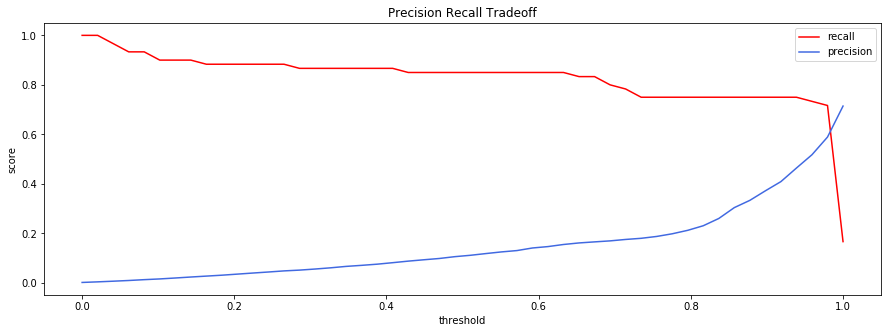

In [136]:
# get validation probability predictions
probs_val = lr.predict_proba(X_val)[:, 1]

# plot precision recall tradeoff
tradeoff_plot(y_val, probs_val)

We can see here that increasing the precision to around %20-%30 would drop the recall lower than the baseline. Perhaps tuning the hyper parameters would change that. 

## 1.5 Hyper Parameter Tuning

Here I will tune the hyper parameters of the model. I will be changing "C", which is the inverse of the learning rate, and "class_weight", which changes the learning rate based on class. I will create a parameter grid and print out the training and validation results for each combination of parameters. I will do this on the data we used with the baseline model as well as the resampled data. I will be chaning the probability thresholds to help get the best recall scores. For the resampled data I will find the best threshold using the validation set.

In [96]:
# normal 
param_grid = ParameterGrid({
    "C":[0.1, 1, 10, 100],
    "class_weight":[{0:2, 1:1}, {0:1, 1:1}, {0:1, 1:2}]
})

print("\n\nBaseline Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
for p in param_grid:
    lr.set_params(**p)
    print(p)
    fit_predict(lr, X_train, y_train, X_val, y_val)
    
    
print("\n\nResampled Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~")
for p in param_grid:
    lr.set_params(**p)
    lr.fit(X_train_rs, y_train_rs)
    probs_train = lr.predict_proba(X_train_rs)[:, 1]
    probs_val = lr.predict_proba(X_val)[:, 1]
    yhat_train = apply_threshold(probs_train, 0.99)
    yhat_val = apply_threshold(probs_val, 0.99)
    print(p)
    print("training")
    get_scores(y_train_rs, yhat_train)
    print("validation")
    get_scores(y_val, yhat_val)
    print("\n\n")



Baseline Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'C': 0.1, 'class_weight': {0: 2, 1: 1}}
training
Recall:    0.877
Precision: 0.353

validation
Recall:    0.767
Precision: 0.299

{'C': 0.1, 'class_weight': {0: 1, 1: 1}}
training
Recall:    0.88
Precision: 0.31

validation
Recall:    0.767
Precision: 0.267

{'C': 0.1, 'class_weight': {0: 1, 1: 2}}
training
Recall:    0.883
Precision: 0.309

validation
Recall:    0.767
Precision: 0.261

{'C': 1, 'class_weight': {0: 2, 1: 1}}
training
Recall:    0.877
Precision: 0.332

validation
Recall:    0.8
Precision: 0.294

{'C': 1, 'class_weight': {0: 1, 1: 1}}
training
Recall:    0.883
Precision: 0.307

validation
Recall:    0.783
Precision: 0.261

{'C': 1, 'class_weight': {0: 1, 1: 2}}
training
Recall:    0.883
Precision: 0.301

validation
Recall:    0.8
Precision: 0.267

{'C': 10, 'class_weight': {0: 2, 1: 1}}
training
Recall:    0.871
Precision: 0.334

validation
Recall:    0.783
Precision: 0.294

{'C': 10, 'class_weight': {0: 1, 1: 1}}
training
Re

## 1.6 Final Logistic Regression Model

I got the best results by taking the baseline model and changing "C" to 10. Now I will fit the model and save the best threshold. I will also print the results out again.

In [137]:
lr.set_params(C=10)

lr.fit(X_train, y_train)

probs_train = lr.predict_proba(X_train)[:, 1]
probs_val = lr.predict_proba(X_val)[:, 1]

find_best_threshold(y_train, probs_train)

0.0045000000000000005

In [138]:
yhat_train = apply_threshold(probs_train, 0.0045)
yhat_val = apply_threshold(probs_val, 0.0045)

print("training")
get_scores(y_train, yhat_train)
print("validation")
get_scores(y_val, yhat_val)

training
Recall:    0.871
Precision: 0.334
validation
Recall:    0.783
Precision: 0.294


''

By tuning the hyper-parameters I achieved a validation score of %78 recall and %29 precision with the logistic regression classifier.

# 2.0 Random Forest Classifier

## 2.1 Baseline Model

Now I will create a baseline random forest classifier and see how well it performs on the data. I will also look at the feature importances to see if any features should be removed.

In [7]:
# create random forest object
rf = RandomForestClassifier()

# fit, set threshold, predict and get scores
fit_predict(rf, X_train, y_train, X_val, y_val)

training
Recall:    1.0
Precision: 0.513

validation
Recall:    0.883
Precision: 0.277



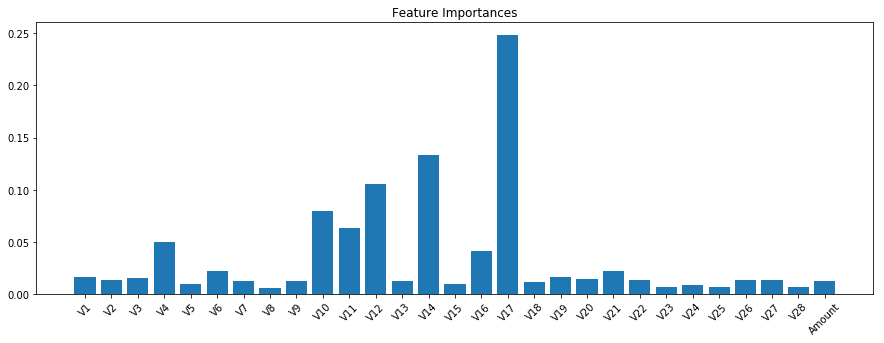

In [14]:
# examine feature importances
plt.figure(figsize=(15, 5))
plt.bar(X_train.columns, rf.feature_importances_)
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.show()

Lets plot one of the model's trees to see how it is making decisions. I learned how to plot trees from this <a href=https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c>medium post </a> by Will Koehrsen


In [44]:
# grab a random tree from the model
tree = rf.estimators_[2]


# save image in .png form
export_graphviz(tree, out_file="rf_tree_plot.dot",
                feature_names=X_train.columns, rounded=True,
                filled=True)

# convert to png
from subprocess import call
call(['dot', '-Tpng', 'rf_tree_plot.dot', '-o', 'rf_tree_plot.png', '-Gdpi=600'])


# display Image
Image("rf_tree_plot.png")

We can see here that the tree is incredibly complex. This may lead to over fitting. Lets see how it performs with a max depth of 3.

In [45]:
# create random forest object with max depth of 3
rf = RandomForestClassifier(max_depth=3) 

# fit, set threshold, predict and get scores
fit_predict(rf, X_train, y_train, X_val, y_val)

training
Recall:    0.833
Precision: 0.355

validation
Recall:    0.883
Precision: 0.361



Now lets make another tree diagram.

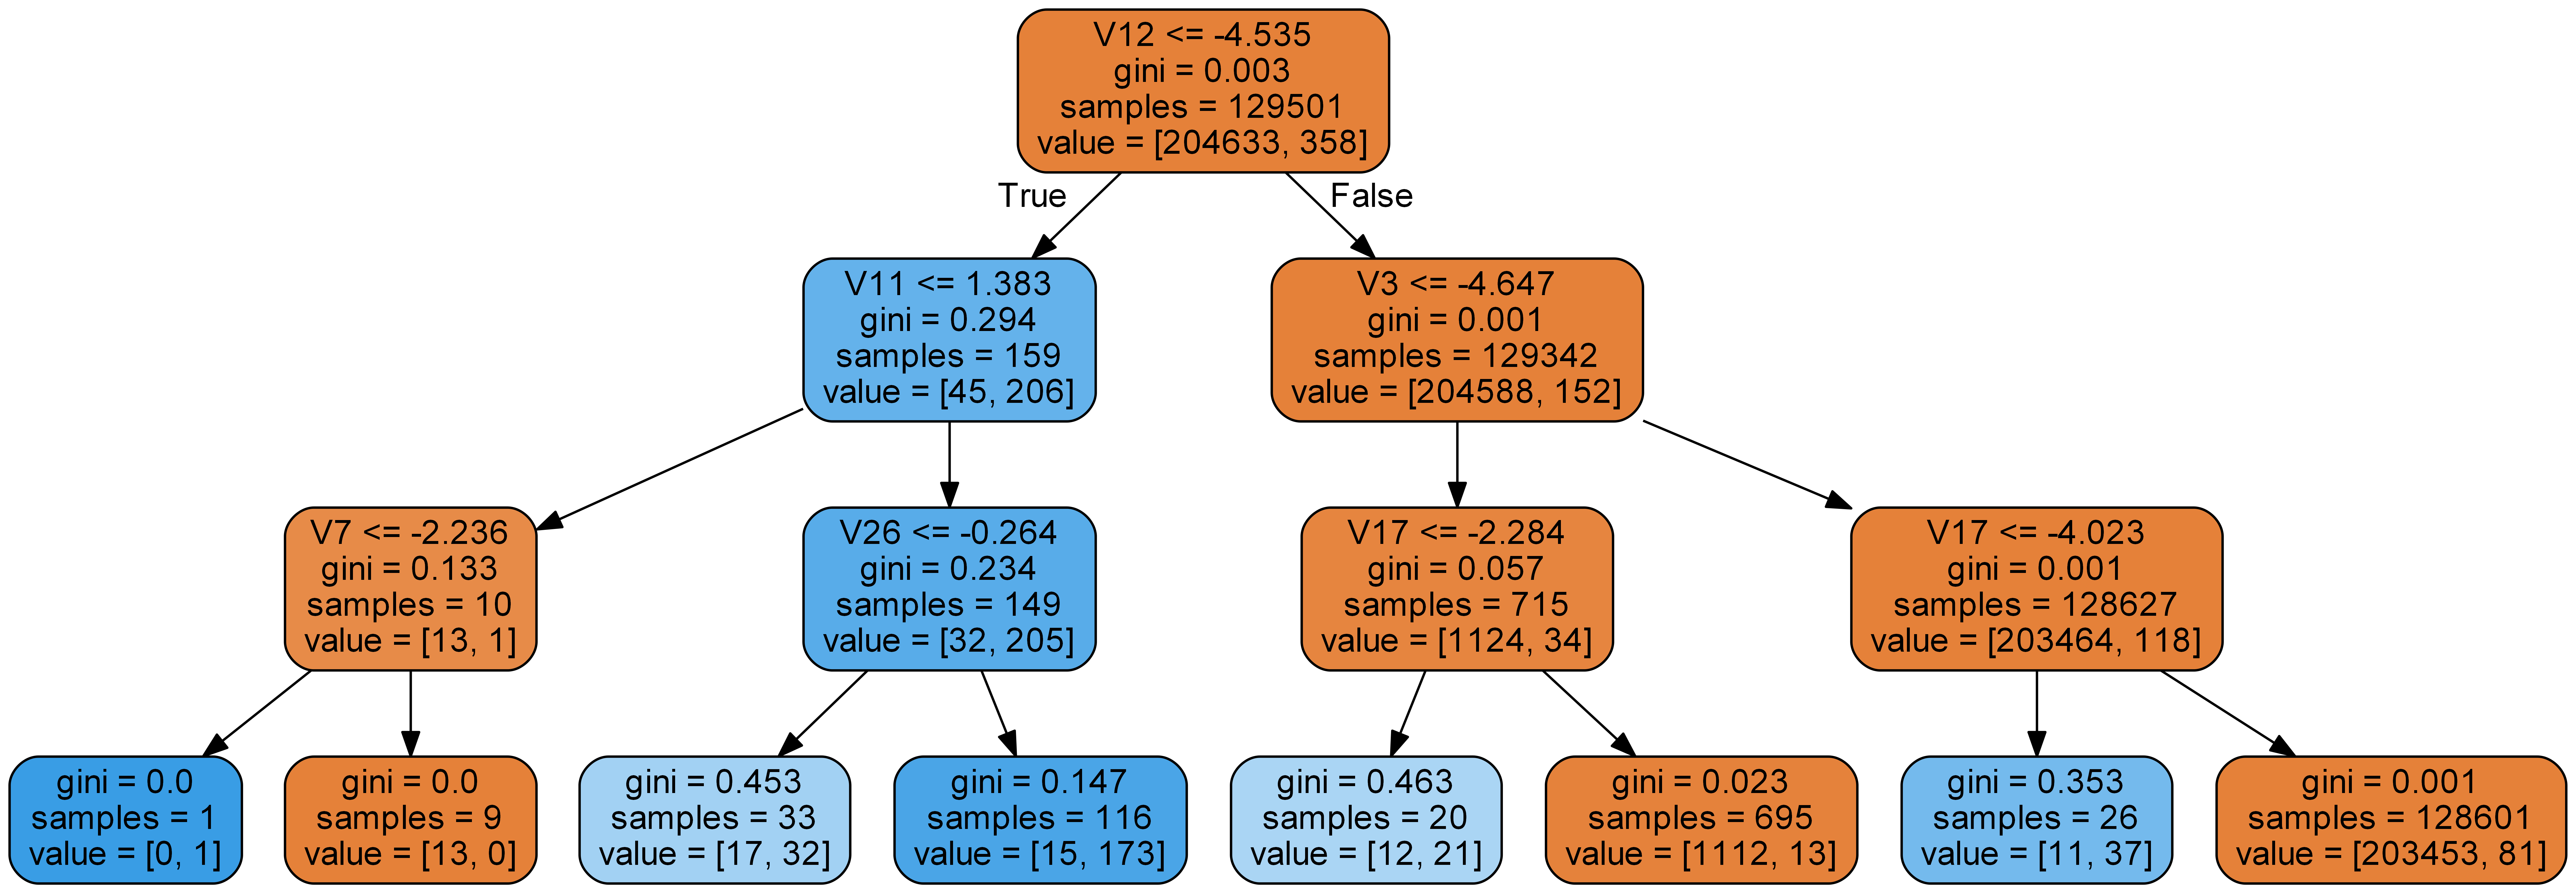

In [47]:
# grab a random tree from the model
tree = rf.estimators_[2]


# save image in .png form
export_graphviz(tree, out_file="rf_tree_plot2.dot",
                feature_names=X_train.columns, rounded=True,
                filled=True)

# convert to png
from subprocess import call
call(['dot', '-Tpng', 'rf_tree_plot2.dot', '-o', 'rf_tree_plot2.png', '-Gdpi=600'])


# display Image
Image("rf_tree_plot2.png")

We can see here, that for this specific tree (1 out of 50) V12, V11, and V26 are important for detecting most of the frauds.

## 2.2 Feature Selection

There seems to be 5 features that have a feature importance of atleast %5. I will simply select these and see if it improves model performance.

In [48]:
# zip together feature names and feature importances then form into a list
name_and_importance = list(zip(X_train.columns, rf.feature_importances_))

# sort list by feature importance in descending order
name_and_importance = sorted(name_and_importance, key=lambda x: x[1], reverse=True)

# create a list to hold feature names
best_feats = []

# add feature names to best_feats if there importances are in the top 5
for name, importance in name_and_importance[:5]:
    best_feats.append(name)
    
# display best features
best_feats

['V12', 'V10', 'V17', 'V14', 'V11']

In [49]:
# make new X_train and X_val variables only using the best features
X_train_bf, X_val_bf = X_train[best_feats], X_val[best_feats]

In [50]:
# run the random forest on only the best features
fit_predict(rf, X_train_bf, y_train, X_val_bf, y_val)

training
Recall:    0.839
Precision: 0.304

validation
Recall:    0.883
Precision: 0.327



## 2.3 PCA

I already have some PCA transformed data, so I will see if the random forest works well on it.

In [23]:
# run the random forest on PCA transformed data
fit_predict(rf, X_train_pca, y_train, X_val_pca, y_val)

training
Recall:    1.0
Precision: 0.513

validation
Recall:    0.9
Precision: 0.29



# 2.4 Resampling

Now I will use the already resampled data and see if it improves the results. Instead of printing out the scores directly I will plot the precision recall tradeoff for both the training and validation sets.

In [27]:
# fit the random forest on the resampled data
rf.fit(X_train_rs, y_train_rs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
# get the probability predictions for the training and validation sets
probs_train = rf.predict_proba(X_train_rs)[:, 1]
probs_val = rf.predict_proba(X_val)[:, 1]

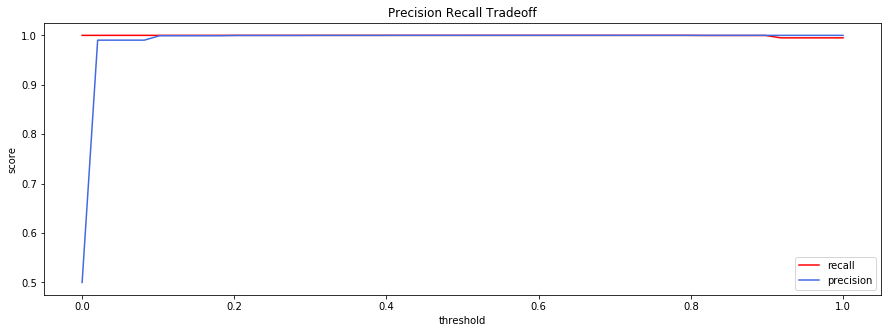

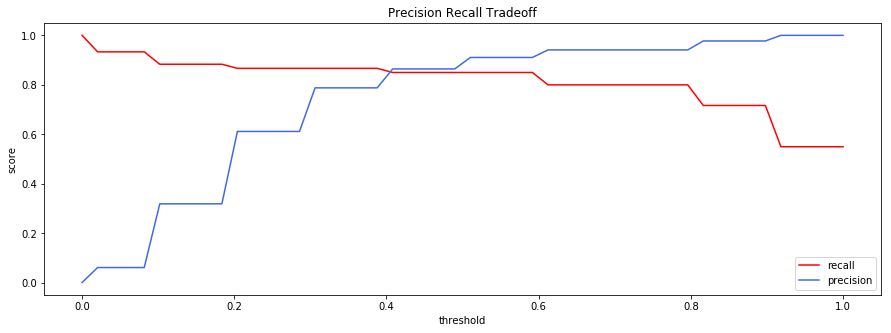

In [30]:
# plot the precision recall tradeoff for the training and validation sets
tradeoff_plot(y_train_rs, probs_train)
tradeoff_plot(y_val, probs_val)

It seems the best threshold is around 0.15. Lets see the validation results for that threshold.

In [32]:
# get predictions using threshold of 0.15
yhat_val = predict_w_threshold(rf, X_val, 0.15)

# print scores
get_scores(y_val, yhat_val)

Recall:    0.883
Precision: 0.319


''

## 2.5 Hyper Parameter Tuning

Now I will tune the max depth of the random forest to see if any further improvements can be made. I will use the original data as well as the resampled data. Keep in mind the resampled data is causing some overfitting. I will be using a parameter grid and printing out the results for each parameter combination. For the resampled data I am going to choose the probability threshold of 0.15 for now, since it worked well on the resampled data I experimented with before.

In [53]:
# normal 
param_grid = ParameterGrid({
    "max_depth":[2, 3, 4, None]
})

print("\n\nBaseline Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
for p in param_grid:
    rf.set_params(**p)
    print(p)
    fit_predict(rf, X_train, y_train, X_val, y_val)
    
    
print("\n\nResampled Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~")
for p in param_grid:
    rf.set_params(**p)
    rf.fit(X_train_rs, y_train_rs)
    probs_train = rf.predict_proba(X_train_rs)[:, 1]
    probs_val = rf.predict_proba(X_val)[:, 1]
    yhat_train = apply_threshold(probs_train, 0.15)
    yhat_val = apply_threshold(probs_val, 0.15)
    print(p)
    print("training")
    get_scores(y_train_rs, yhat_train)
    print("validation")
    get_scores(y_val, yhat_val)
    print("\n\n")



Baseline Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 2}
training
Recall:    0.83
Precision: 0.491

validation
Recall:    0.883
Precision: 0.5

{'max_depth': 3}
training
Recall:    0.833
Precision: 0.326

validation
Recall:    0.883
Precision: 0.333

{'max_depth': 4}
training
Recall:    0.842
Precision: 0.315

validation
Recall:    0.883
Precision: 0.338

{'max_depth': None}
training
Recall:    1.0
Precision: 0.504

validation
Recall:    0.9
Precision: 0.265



Resampled Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 2}
training
Recall:    0.976
Precision: 0.656
validation
Recall:    1.0
Precision: 0.003



{'max_depth': 3}
training
Recall:    0.977
Precision: 0.775
validation
Recall:    0.983
Precision: 0.006



{'max_depth': 4}
training
Recall:    0.985
Precision: 0.797
validation
Recall:    1.0
Precision: 0.006



{'max_depth': None}
training
Recall:    1.0
Precision: 0.999
validation
Recall:    0.9
Precision: 0.32





## 2.6 Final Random Forest Model

It seems the model did the best with the max depth set to "None", but I can't help to think the model will over fit (see above image of the huge decision tree). So I will use the regular data and set the max depth to 3. Lets get a look at the precision recall tradeoff and the final results.

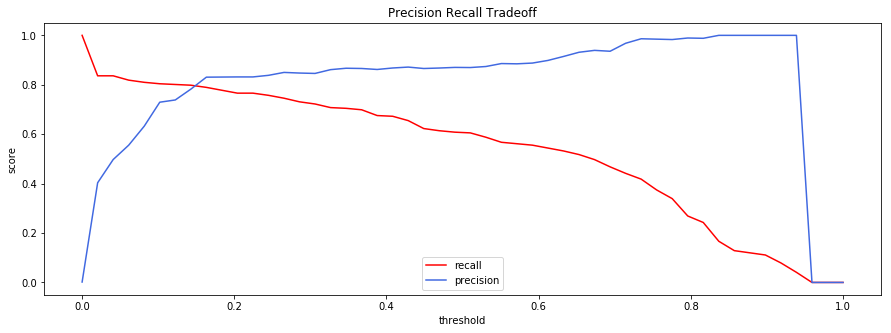

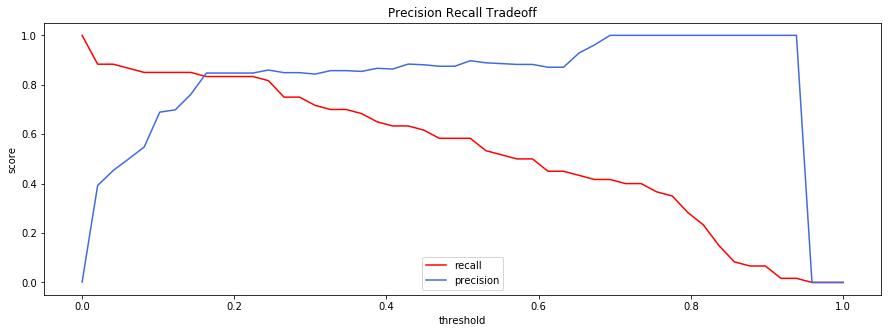

In [54]:
# set the parameters for the random forest
rf = RandomForestClassifier(max_depth=3)

# fit on the regular data
rf.fit(X_train, y_train)

# find the probability predictions for the train and validation sets
probs_train = rf.predict_proba(X_train)[:, 1]
probs_val = rf.predict_proba(X_val)[:, 1]

# plot precision recall tradeoff for both sets
tradeoff_plot(y_train, probs_train)
tradeoff_plot(y_val, probs_val)

They seem similar so I will use the training set to set the theshold. Then I will print out the resulting scores.

In [55]:
# find threshold using training set
threshold = find_best_threshold(y_train, probs_train)

# make predictions using threshold
yhat_train = predict_w_threshold(rf, X_train, threshold)
yhat_val = predict_w_threshold(rf, X_val, threshold)

# print scores
print("training")
get_scores(y_train, yhat_train)
print("validation")
get_scores(y_val, yhat_val)


training
Recall:    0.836
Precision: 0.301
validation
Recall:    0.883
Precision: 0.291


''